<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

This will save files to your local machine if `save_files` is set to True.

# Change Inputs Here

In [1]:
task = "numerals"  # choose: numerals, numwords, months
prompt_types = ['done', 'lost', 'names']
num_samps_per_ptype = 4 #768 512

# model_name = "gpt2-small"

save_files = True
run_on_other_tasks = True

# Setup

In [2]:
%%capture
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
# import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle
from google.colab import files

import matplotlib.pyplot as plt
import statistics

In [4]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [5]:
torch.set_grad_enabled(False)

# Load Model

In [6]:
from transformers import LlamaForCausalLM, LlamaTokenizer

In [7]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) m
Invalid input. Must be one of ('y', 'yes', '1', 'n', 'no', '0', '')
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [8]:
LLAMA_2_7B_CHAT_PATH = "meta-llama/Llama-2-7b-chat-hf"

# tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH)
tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH, use_fast= False, add_prefix_space= False)
hf_model = LlamaForCausalLM.from_pretrained(LLAMA_2_7B_CHAT_PATH, low_cpu_mem_usage=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [9]:
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import HookedTransformer

In [10]:
model = HookedTransformer.from_pretrained(
    LLAMA_2_7B_CHAT_PATH,
    hf_model = hf_model,
    tokenizer = tokenizer,
    device = "cpu",
    fold_ln = False,
    center_writing_weights = False,
    center_unembed = False,
)

del hf_model

model = model.to("cuda" if torch.cuda.is_available() else "cpu")

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Moving model to device:  cuda


# Test prompts

In [11]:
# Get list of arguments to pass to `generate` (specifically these are the ones relating to sampling)
generate_kwargs = dict(
    do_sample = False, # deterministic output so we can compare it to the HF model
    top_p = 1.0, # suppresses annoying output errors
    temperature = 1.0, # suppresses annoying output errors
)

prompt =  "uno dos tres"
output = model.generate(prompt, max_new_tokens=5, **generate_kwargs)
print(output)

  0%|          | 0/5 [00:00<?, ?it/s]

uno dos tres" (One, Two


Next char it generates is ' ', not '8', so put a space at end of your prompts

In [12]:
prompt =  "uno dos tres "
output = model.generate(prompt, max_new_tokens=1, **generate_kwargs)
print(output)

  0%|          | 0/1 [00:00<?, ?it/s]

uno dos tres 1


In [15]:
prompt =  "uno dos tres cuatro "
output = model.generate(prompt, max_new_tokens=1, **generate_kwargs)
print(output)

  0%|          | 0/1 [00:00<?, ?it/s]

uno dos tres cuatro 5


In [19]:
prompt =  "uno dos tres cuatro"
output = model.generate(prompt, max_new_tokens=1, **generate_kwargs)
print(output)

  0%|          | 0/1 [00:00<?, ?it/s]

uno dos tres cuatro cinco


In [18]:
prompt =  "uno dos tres cuatro cinco"
output = model.generate(prompt, max_new_tokens=1, **generate_kwargs)
print(output)

  0%|          | 0/1 [00:00<?, ?it/s]

uno dos tres cuatro cinco seis


# Import functions from repo

In [13]:
!git clone https://github.com/apartresearch/seqcont_circuits.git
%cd /content/seqcont_circuits/src/iter_node_pruning

Cloning into 'seqcont_circuits'...
remote: Enumerating objects: 831, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 831 (delta 161), reused 221 (delta 89), pack-reused 534
Receiving objects: 100% (831/831), 16.50 MiB | 9.30 MiB/s, done.
Resolving deltas: 100% (524/524), done.
/content/seqcont_circuits/src/iter_node_pruning


In [14]:
# from dataset import Dataset
from metrics import *
from head_ablation_fns import *
from mlp_ablation_fns import *
from node_ablation_fns import *
from loop_node_ablation_fns import *

# Functions

In [26]:
class Dataset:
    def __init__(self, prompts, tokenizer):  # , S1_is_first=False
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.corr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["corr"])[-1] for prompt in self.prompts
        ]
        self.incorr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["incorr"])[-1] for prompt in self.prompts
        ]

        pos_dict = {}
        # for i in range(1, 4):
        #     pos_dict['S'+str(i)] = i
        list_tokens = tokenizer.tokenize('2 4 6 ')
        for i, tok_as_str in enumerate(list_tokens):
            pos_dict['S'+str(i)] = i

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        # for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
        for targ in [key for key in pos_dict]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = self.tokenizer.tokenize(input_text)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

# Load datasets

Because llama-2 tokenizer treats space as a token, remember to ablate even the spaces too, not just the numbers!

In [20]:
tokenizer.tokenize('uno dos tres cuatro')

['uno', '▁dos', '▁tres', '▁cuatro']

In [40]:
def generate_prompts():
    prompts_list = []
    prompt_dict = {
        'corr': ' cinco',
        'incorr': ' cuatro',
        'text': f"uno dos tres cuatro"
    }
    list_tokens = tokenizer.tokenize('uno dos tres cuatro')
    for i, tok_as_str in enumerate(list_tokens):
        if tok_as_str == '▁':
            prompt_dict['S'+str(i)] = ' '
        else:
            prompt_dict['S'+str(i)] = tok_as_str
    prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts()
prompts_list

[{'corr': ' cinco',
  'incorr': ' cuatro',
  'text': 'uno dos tres cuatro',
  'S0': 'uno',
  'S1': '▁dos',
  'S2': '▁tres',
  'S3': '▁cuatro'}]

In [39]:
import random

def generate_prompts_list_corr():
    prompts_list = []
    r1 = random.randint(1, 9)
    r2 = random.randint(1, 9)
    r3 = random.randint(1, 9)
    prompt_dict = {
        'corr': ' cinco',
        'incorr': ' cuatro',
        # 'text': f"{r1} {r2} {r3} "
        'text': f"uno cinco cuatro tres"
    }
    # list_tokens = tokenizer.tokenize(f"{r1} {r2} {r3} ")
    list_tokens = tokenizer.tokenize(f"uno cinco cuatro tres")
    for i, tok_as_str in enumerate(list_tokens):
        if tok_as_str == '▁':
            prompt_dict['S'+str(i)] = ' '
        else:
            prompt_dict['S'+str(i)] = tok_as_str
    prompts_list.append(prompt_dict)
    return prompts_list

prompts_list_2 = generate_prompts_list_corr()
prompts_list_2

[{'corr': ' cinco',
  'incorr': ' cuatro',
  'text': 'uno cinco cuatro tres',
  'S0': 'uno',
  'S1': '▁cinco',
  'S2': '▁cuatro',
  'S3': '▁tres'}]

If dos is in front, tokenizer makes it 2 tokens. Else, it's 1 token

In [41]:
dataset = Dataset(prompts_list, model.tokenizer)
dataset.toks.shape

torch.Size([1, 5])

In [42]:
dataset_2 = Dataset(prompts_list_2, model.tokenizer) #, S1_is_first=True)
dataset_2.toks.shape

torch.Size([1, 5])

# Get orig score

In [43]:
model.reset_hooks(including_permanent=True)
logits_original = model(dataset.toks)
orig_score = get_logit_diff(logits_original, dataset)

In [44]:
next_token = logits_original[0, -1].argmax(dim=-1)  # logits have shape [1, sequence_length, vocab_size]
next_char = model.to_string(next_token)
print(repr(next_char))

' cinco'


In [45]:
orig_score

tensor(-2.5691, device='cuda:0')

In [46]:
import gc

del(logits_original)
torch.cuda.empty_cache()
gc.collect()

0

# Find Impt Attention Heads from Full

## test unablated run

Llama-2 has 32 heads per layer

In [47]:
lst = [(layer, head) for layer in range(32) for head in range(0, 32)]
CIRCUIT = {}
SEQ_POS_TO_KEEP = {}

list_tokens = tokenizer.tokenize('2 4 6 ')
for i, tok_as_str in enumerate(list_tokens):
    CIRCUIT['S'+str(i)] = lst
    SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
    if i == 5:
        SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
# for i in range(1, 4):
#     CIRCUIT['S'+str(i)] = lst
#     # if i == 3:
#     #     SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
#     # else:
#     SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
SEQ_POS_TO_KEEP

{'S0': 'S0', 'S1': 'S1', 'S2': 'S2', 'S3': 'S3', 'S4': 'S4', 'S5': 'end'}

In [48]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
logits_minimal = model(dataset.toks)

new_score = get_logit_diff(logits_minimal, dataset)

In [49]:
next_token = logits_minimal[0, -1].argmax(dim=-1)  # logits have shape [1, sequence_length, vocab_size]
next_char = model.to_string(next_token)
print(repr(next_char))

' cinco'


In [50]:
print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
new_score

Average logit difference (circuit / full) %: 100.0000


tensor(-2.5691, device='cuda:0')

In [51]:
import gc

del(logits_minimal)
torch.cuda.empty_cache()
gc.collect()

0

## run each

In [52]:
def ablate_head_from_full(
        lst: List[Tuple[int, int]],
        model: HookedTransformer,
        dataset: Dataset,
        dataset_2: Dataset,
        orig_score: float,
        print_output: bool = True,
) -> float:
    # CIRCUIT contains the components to not ablate
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}

    list_tokens = tokenizer.tokenize('2 4 6 ')
    for i, tok_as_str in enumerate(list_tokens):
        CIRCUIT['S'+str(i)] = lst
        SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
        if i == 5:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    logits_minimal = model(dataset.toks)

    new_score = get_logit_diff(logits_minimal, dataset)
    if print_output:
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    return 100 * new_score / orig_score

In [53]:
circ = [(layer, head) for layer in range(32) for head in range(0, 32)]
# to_loop = circ.copy() # (L,H) to remove
to_loop = [(layer, head) for layer in range(32) for head in range(0, 32)]

lh_scores = {}
for lh in to_loop:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = ablate_head_from_full(copy_circuit, model, dataset, dataset_2, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 0)
Average logit difference (circuit / full) %: 102.0000
removed: (0, 1)
Average logit difference (circuit / full) %: 101.1054
removed: (0, 2)
Average logit difference (circuit / full) %: 92.3179
removed: (0, 3)
Average logit difference (circuit / full) %: 97.5686
removed: (0, 4)
Average logit difference (circuit / full) %: 95.8645
removed: (0, 5)
Average logit difference (circuit / full) %: 98.0989
removed: (0, 6)
Average logit difference (circuit / full) %: 110.5970
removed: (0, 7)
Average logit difference (circuit / full) %: 106.6522
removed: (0, 8)
Average logit difference (circuit / full) %: 101.7385
removed: (0, 9)
Average logit difference (circuit / full) %: 99.2160
removed: (0, 10)
Average logit difference (circuit / full) %: 98.0838
removed: (0, 11)
Average logit difference (circuit / full) %: 101.2205
removed: (0, 12)
Average logit difference (circuit / full) %: 96.4845
removed: (0, 13)
Average logit difference (circuit / full) %: 123.0296
removed: (0, 14)
Averag

In [54]:
# Sort the dictionary by values in descending order
sorted_lh_scores = sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True)

# Iterate over the top 10 items and print them
i=1
for lh, score in sorted_lh_scores[:50]:
    modified_score = -round(100 - score, 2)
    print(i, lh, modified_score)
    i+=1

1 (20, 17) -81.04
2 (16, 0) -62.51
3 (22, 25) -36.77
4 (18, 9) -32.97
5 (5, 26) -25.72
6 (2, 22) -23.59
7 (4, 7) -20.41
8 (29, 5) -17.37
9 (6, 14) -16.79
10 (1, 21) -13.74
11 (26, 2) -13.68
12 (5, 24) -13.43
13 (23, 2) -12.37
14 (18, 31) -11.98
15 (2, 13) -11.53
16 (1, 24) -10.66
17 (15, 25) -10.45
18 (7, 1) -10.08
19 (3, 22) -8.46
20 (8, 21) -8.27
21 (1, 17) -8.25
22 (18, 2) -8.02
23 (1, 6) -8.01
24 (0, 2) -7.68
25 (26, 28) -7.61
26 (5, 17) -7.4
27 (23, 17) -7.18
28 (19, 11) -6.58
29 (16, 29) -6.49
30 (5, 12) -6.03
31 (8, 10) -5.88
32 (3, 6) -5.67
33 (7, 7) -5.65
34 (2, 2) -5.62
35 (28, 30) -5.45
36 (6, 11) -5.14
37 (5, 9) -4.77
38 (21, 14) -4.63
39 (4, 4) -4.56
40 (30, 27) -4.33
41 (0, 4) -4.14
42 (18, 19) -4.02
43 (17, 6) -3.96
44 (4, 17) -3.92
45 (14, 12) -3.82
46 (28, 22) -3.73
47 (20, 8) -3.73
48 (7, 26) -3.69
49 (9, 4) -3.66
50 (19, 2) -3.54


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

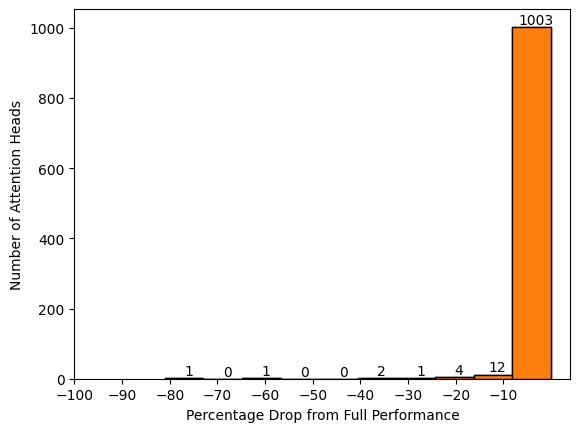

In [55]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}
scores = list(lh_scores_drop.values())
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

# plt.show()

if save_files:
    pdf_filename = 'lh_scores_distribution.pdf'
    plt.savefig(pdf_filename)
    files.download(pdf_filename)

In [56]:
scores = list(lh_scores_drop.values())
mean_score = statistics.mean(scores)
print("Mean of the scores:", mean_score)

if save_files:
    with open('numerals_lh_scores.pkl', 'wb') as file:
        pickle.dump(lh_scores, file)
        files.download('numerals_lh_scores.pkl')

Mean of the scores: -0.8892347738146782


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## plot heatmap

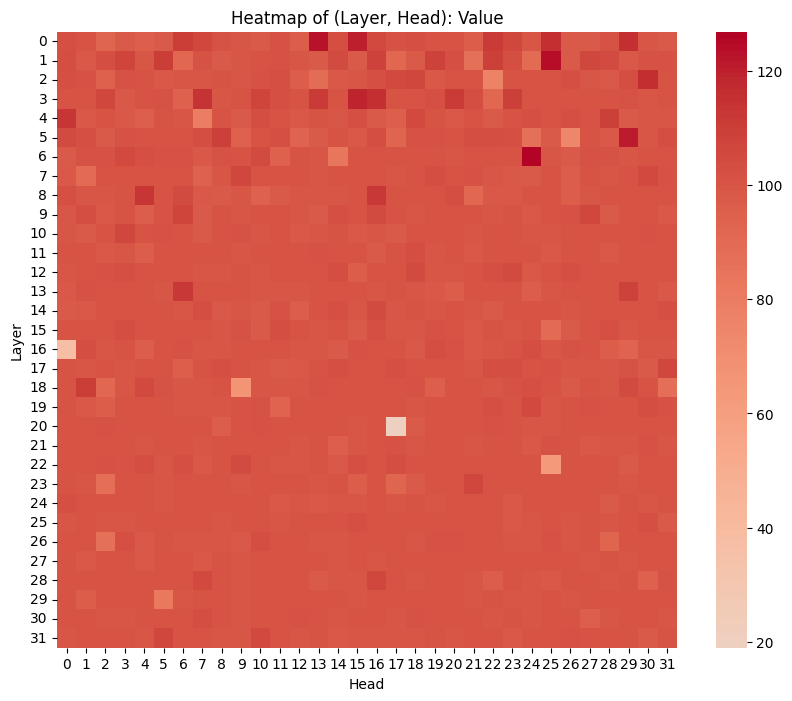

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert dictionary to a DataFrame
data_list = [(key[0], key[1], value) for key, value in lh_scores.items()]
df = pd.DataFrame(data_list, columns=['Layer', 'Head', 'Value'])

# Create a pivot table
pivot_table = df.pivot(index='Layer', columns='Head', values='Value').fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(pivot_table, cmap='coolwarm', center=0, annot=False, cbar=True)
plt.xlabel('Head')
plt.ylabel('Layer')
plt.title('Heatmap of (Layer, Head): Value')

# Rotate y-axis numbers to horizontal
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.show()

# Find Impt MLPs from Full

In [58]:
for i in range(32):
    lst = [layer for layer in range(32) if layer != i]
    perc_of_orig = ablate_MLP_from_full(lst, model, dataset, dataset_2, orig_score, print_output=False).item()
    print(i, perc_of_orig)

0 113.06269836425781
1 127.03826904296875
2 147.672119140625
3 45.513282775878906
4 -8.949407577514648
5 162.65380859375
6 156.14051818847656
7 118.9484634399414
8 113.21320343017578
9 97.59908294677734
10 132.7599639892578
11 33.77241134643555
12 101.09874725341797
13 19.534109115600586
14 115.26976013183594
15 97.64556121826172
16 117.79710388183594
17 50.474056243896484
18 84.0156478881836
19 100.42420196533203
20 130.9434051513672
21 101.33148193359375
22 82.75997924804688
23 105.11568450927734
24 47.59280776977539
25 86.42433166503906
26 77.17523193359375
27 100.19052124023438
28 90.59381866455078
29 90.16827392578125
30 99.01611328125
31 101.238525390625


# Node Ablation Iteration

In [ ]:
threshold = 20
curr_circ_heads = []
curr_circ_mlps = []
prev_score = 100
new_score = 0
iter = 1
all_comp_scores = []
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    old_circ_heads = curr_circ_heads.copy() # save old before finding new one
    old_circ_mlps = curr_circ_mlps.copy()
    curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
    if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
        break
    all_comp_scores.append(comp_scores)
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circ_heads = curr_circ_heads.copy()
    old_circ_mlps = curr_circ_mlps.copy()
    curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_forw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
    if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
        break
    all_comp_scores.append(comp_scores)
    iter += 1


backw prune, iter  1
11
(cand circuit / full) %: 78.8354
11 0
(cand circuit / full) %: 99.7405
Removed: (11, 0)
11 1
(cand circuit / full) %: 100.1990
Removed: (11, 1)
11 2
(cand circuit / full) %: 100.6725
Removed: (11, 2)
11 3
(cand circuit / full) %: 101.3111
Removed: (11, 3)
11 4
(cand circuit / full) %: 101.5750
Removed: (11, 4)
11 5
(cand circuit / full) %: 101.8257
Removed: (11, 5)
11 6
(cand circuit / full) %: 102.0605
Removed: (11, 6)
11 7
(cand circuit / full) %: 102.3034
Removed: (11, 7)
11 8
(cand circuit / full) %: 100.9598
Removed: (11, 8)
11 9
(cand circuit / full) %: 100.5795
Removed: (11, 9)
11 10
(cand circuit / full) %: 99.2775
Removed: (11, 10)
11 11
(cand circuit / full) %: 100.1830
Removed: (11, 11)
10
(cand circuit / full) %: 63.1566
10 0
(cand circuit / full) %: 100.2873
Removed: (10, 0)
10 1
(cand circuit / full) %: 99.4857
Removed: (10, 1)
10 2
(cand circuit / full) %: 101.9172
Removed: (10, 2)
10 3
(cand circuit / full) %: 102.0514
Removed: (10, 3)
10 4
(can

In [ ]:
with open('numerals_bf_20_scores.pkl', 'wb') as file:
    pickle.dump(all_comp_scores, file)
files.download('numerals_bf_20_scores.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
curr_circ_heads

[(0, 1),
 (1, 5),
 (4, 4),
 (4, 10),
 (5, 0),
 (6, 1),
 (6, 6),
 (6, 10),
 (7, 11),
 (8, 1),
 (8, 6),
 (8, 8),
 (8, 9),
 (9, 1)]

In [ ]:
curr_circ_mlps

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

## Find most impt heads from circ

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, curr_circ_heads, curr_circ_mlps)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 81.0075


In [ ]:
lh_scores = {}
for lh in curr_circ_heads:
    copy_circuit = curr_circ_heads.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    model = add_ablation_hook_MLP_head(model, dataset_2, copy_circuit, curr_circ_mlps)

    new_logits = model(dataset.toks)
    new_score = get_logit_diff(new_logits, dataset).item()
    new_perc = 100 * new_score / orig_score
    print(f"(cand circuit / full) %: {new_perc:.4f}")
    lh_scores[lh] = new_perc

removed: (0, 1)
(cand circuit / full) %: 36.7208
removed: (1, 5)
(cand circuit / full) %: 53.1754
removed: (4, 4)
(cand circuit / full) %: 47.8225
removed: (4, 10)
(cand circuit / full) %: 76.1406
removed: (5, 0)
(cand circuit / full) %: 75.9876
removed: (6, 1)
(cand circuit / full) %: 70.7259
removed: (6, 6)
(cand circuit / full) %: 73.4448
removed: (6, 10)
(cand circuit / full) %: 67.0089
removed: (7, 11)
(cand circuit / full) %: 39.3698
removed: (8, 1)
(cand circuit / full) %: 68.0800
removed: (8, 6)
(cand circuit / full) %: 69.9912
removed: (8, 8)
(cand circuit / full) %: 65.7820
removed: (8, 9)
(cand circuit / full) %: 76.9148
removed: (9, 1)
(cand circuit / full) %: 46.0634


In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score.item(), 2))

(0, 1) -0.98
(7, 11) 1.67
(9, 1) 8.36
(4, 4) 10.12
(1, 5) 15.48
(8, 8) 28.08
(6, 10) 29.31
(8, 1) 30.38
(8, 6) 32.29
(6, 1) 33.03
(6, 6) 35.74
(5, 0) 38.29
(4, 10) 38.44
(8, 9) 39.21


# Run on other task's circuits

In [ ]:
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 0), (6, 1), (6, 6), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 81.0075


In [ ]:
# numwords
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 8), (6, 1), (6, 6), (6, 10), (7, 2), (7, 6), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (9, 5), (9, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 87.3488


In [ ]:
# months
heads_not_ablate = [(0, 1), (0, 5), (4, 4), (6, 1), (6, 6), (6, 10), (7, 6), (7, 9), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 43.7440


In [ ]:
CIRCUIT = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(2, 2), (4, 11)],
}

import itertools
a = [val for val in CIRCUIT.values()]
IOI_heads = list(itertools.chain.from_iterable(a))

mlps_not_ablate = list(range(12))

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, IOI_heads, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: -6.6992


In [ ]:
### months w/ MLP 11

heads_not_ablate = [(0, 1), (4, 4), (4, 10), (6, 1), (6, 6), (6, 10), (7, 2), (7, 10), (7, 11), (8, 8), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11] # incl 5 makes it 66.1155%

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 37.7001
